### Multi-Agent System for Research and Data Visualization

Multi-Agent System
- This multi-agent system processes a user’s request a through a series of specialized agents and tools: Here a Researcher (agent) gathers data, a Router directs information flow, a Chart Generator (agent) creates visuals, and a Call_tool facilitates agent interactions.
- Architecture is shown below

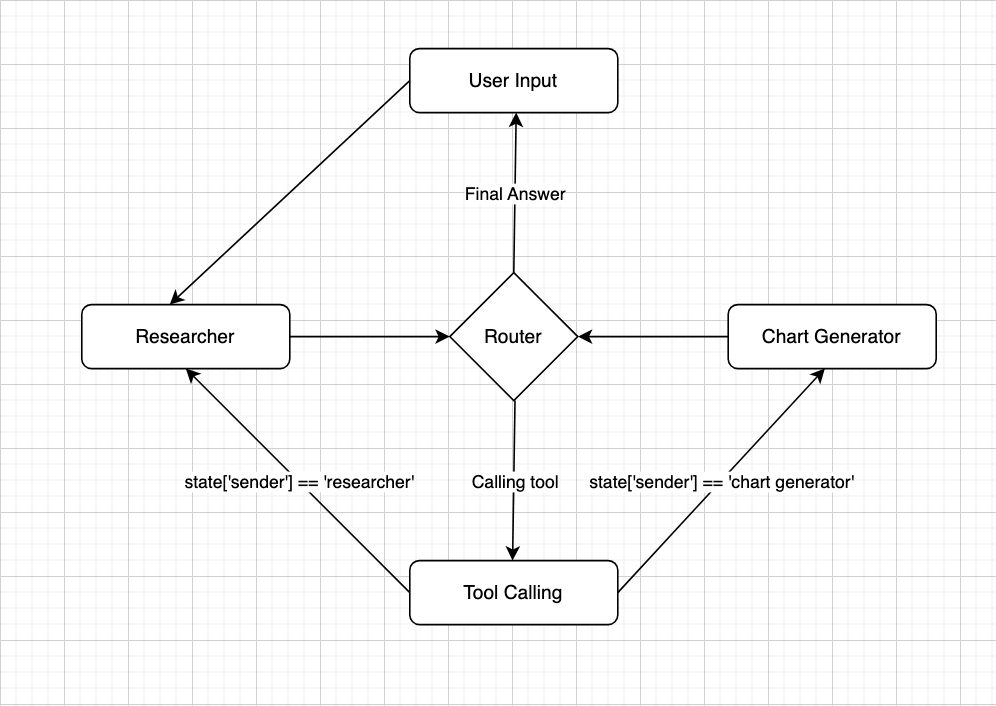

In [1]:
from IPython.display import Image
Image(filename='architecture.png')

#### Creating Agent

In [17]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

#### Adding tools

- Tavily for a search functionality.
- The second tool is a python runtime function to execute generation of a code — The function takes a python code and executes it.

In [25]:
from typing import Annotated
from dotenv import load_dotenv

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

load_dotenv()
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

#### Agent State

- We would be building Stateful agent. Stateful AI agents utilize persistent memory structures to retain and update contextual information across interactions. 
- The messages variable keeps getting appended with new messages, whereas the sender variable gets substituted (this essentially is leveraged by the current agent to understand who the previous agent was)

In [26]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

#### Define the agents

- research_agent: That is responsible for searching the web and gathering information for the chart_agent
- chart_agent: That is responsible for generating and executing python codes and generating charts
- Tool_node: That is responsible for just executing various tools

In [29]:
import functools
from langchain_core.messages import AIMessage
load_dotenv()
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

Define the conditional edges / logic
- If the previous agent is invoking a tool (that is binding to the agent’s llm) then it will update the state to a tool call
- If the previous agent is not invoking a tool call, but is suggesting that its done its job and the final answer is ready, it will update the state to END
- Else, it will update the state to continue

In [30]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

#### Define Graph

- Edge added from the researcher node:
    - If the router says the state needs to be updated to "continue", it will proceed to chart_generator.
    - If the router says the state needs to be updated to "call_tool", it will proceed towards tool "call_tool".
    - If the router says the state needs to be updated to "END", the whole execution will stop
- Edge added from the chart_generator node:
    - If the router says the state needs to be updated to continue, it will proceed to researcher.
    - If the router says the state needs to be updated to "call_tool", it will proceed towards tool "call_tool".
    - If the router says the state needs to be updated to "END", the whole execution will stop
- Edge added from the tool node: It will go back to the sender (the state before tool node was executed) based on the sender variable in the state. 

In [31]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field (the tool calling node does not), meaning this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

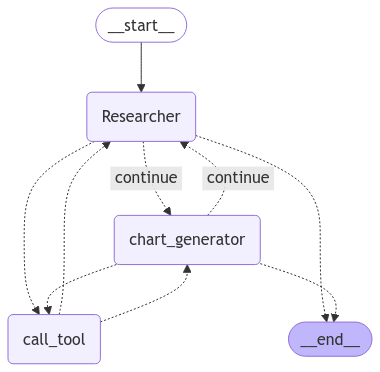

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [33]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch India's GDP for past 5 years and plot a chart of it"
            )
        ],
    },
    {"recursion_limit": 15},
)
for s in events:
    print(s)
    print("----")

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_azjTutHpomhPKxuOlViE550w', 'function': {'arguments': '{"query":"India GDP past 5 years data"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 204, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-bff435e7-8096-4c95-89d6-b343abe7e980-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'India GDP past 5 years data'}, 'id': 'call_azjTutHpomhPKxuOlViE550w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 25, 

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='Here are the GDP figures for India over the past five years:\n\n- **2023**: $3,549.92 billion\n- **2022**: $3,353.47 billion\n- **2021**: $3,167.27 billion\n- **2020**: $2,674.85 billion\n- **2019**: $2,835.61 billion\n\nI will now plot this data in a chart format.', additional_kwargs={'tool_calls': [{'id': 'call_rFRb3u8NeQpGxExGQmXXiMIA', 'function': {'arguments': '{"query":"chart generator"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 116, 'prompt_tokens': 1551, 'total_tokens': 1667, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-c15de1

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='Here are the GDP figures for India over the past five years summarized in table format:\n\n| Year | GDP (in Billion USD) |\n|------|-----------------------|\n| 2023 | $3,549.92             |\n| 2022 | $3,353.47             |\n| 2021 | $3,167.27             |\n| 2020 | $2,674.85             |\n| 2019 | $2,835.61             |\n\nI recommend using an online chart generator to visualize this data. Here are some useful chart-making resources:\n\n1. [Epilocal Chart Maker](https://www.epilocal.com/free-chart-maker/)\n2. [Visme Chart Maker](https://www.visme.co/chart-maker/)\n3. [Stats Kingdom Chart Generator](https://www.statskingdom.com/chart-maker.html)\n4. [Free Tools Touchpoint Chart Maker](https://freetools.touchpoint.com/chart-maker)\n\nYou can input this data into any of these tools to create a beautiful chart. If you need any further assistance or specific formatting for this chart, feel free to ask!', additional_kwargs={'refusal': None

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fNh26d6ofd9yUSVUbaj5pwaP', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for India\'s GDP over the past 5 years\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp = [2835.61, 2674.85, 3167.27, 3353.47, 3549.92]\\n\\n# Creating the plot\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp, marker=\'o\')\\nplt.title(\\"India\'s GDP Over the Past 5 Years\\")\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in Billion USD)\')\\nplt.xticks(years)\\nplt.grid()\\nplt.tight_layout()\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 181, 'prompt_tokens': 2173, 'total_tokens': 2354, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'c

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dngannhOof3jGsIaO0wXcok4', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for India\'s GDP over the past 5 years\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp = [2835.61, 2674.85, 3167.27, 3353.47, 3549.92]\\n\\n# Creating the plot\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp, marker=\'o\')\\nplt.title(\\"India\'s GDP Over the Past 5 Years\\")\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in Billion USD)\')\\nplt.xticks(years)\\nplt.grid()\\nplt.tight_layout()\\n\\n# Save the plot to a file instead\\nplt.savefig(\'/mnt/data/india_gdp_chart.png\')"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 194, 'prompt_tokens': 2549, 'total_tokens': 2743, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens

/var/folders/3v/bb5ldm_90dqdy3cx6268kc8m0000gn/T/ipykernel_8935/3204382042.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
